In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 6.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/school"

Mounted at /content/drive
/content/drive/MyDrive/school


In [3]:
# from detection import *
from ultralytics import YOLO
import torch
import cv2
from google.colab.patches import cv2_imshow
import os

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda")

In [6]:
def is_shot_made(current_center, previous_center, basket):
    # Given a current ball position, previous ball position, and a basket data determine if a shot is made
    # y is distance from the top and x is distance from the left
    # examble basket [1043 255 1076 283] x1, y1, x2, y2
    current_center_x, current_center_y = current_center
    previous_center_y = previous_center[1]


    basket_left, basket_top, basket_right, basket_bottom = basket
    #is ball in the net
    is_x_in_basket = basket_left <= current_center_x and current_center_x <= basket_right
    is_y_in_basket = basket_top <= current_center_y and basket_bottom >= current_center_y
    is_ball_decending = previous_center_y < current_center_y

    return (is_x_in_basket and is_y_in_basket and is_ball_decending)


In [7]:

def is_ball_in_basket(current_ball, prev_ball, basket):
    # Alternative to is_shot_made. Testing showed no improvement in accuracy
    # Given a current ball position, previous ball position, and a basket data determine if a shot is made
    # y is distance from the top and x is distance from the left
    # examble basket [1043 255 1076 283] x1, y1, x2, y2
        # adjust_basket = 0
        # adjust ball = 0
        current_left_x, current_top_y, current_right_x, current_bottom_y = current_ball
        previous_bottom_y = prev_ball[1]


        basket_left, basket_top, basket_right, basket_bottom = basket
        #is ball in the net
        is_x_in_basket = basket_left <= current_left_x and current_right_x <= basket_right
        is_y_in_basket = basket_top <= current_top_y and basket_bottom >= current_bottom_y
        is_ball_decending = previous_bottom_y < current_bottom_y
        return (is_x_in_basket and is_y_in_basket and is_ball_decending)


In [14]:
!unzip video_test_dataset.zip

Archive:  video_test_dataset.zip
   creating: video_test_dataset/
  inflating: __MACOSX/._video_test_dataset  
  inflating: video_test_dataset/.DS_Store  
  inflating: __MACOSX/video_test_dataset/._.DS_Store  
   creating: video_test_dataset/0/
  inflating: __MACOSX/video_test_dataset/._0  
   creating: video_test_dataset/1/
  inflating: __MACOSX/video_test_dataset/._1  
  inflating: video_test_dataset/0/miss_9.mp4  
  inflating: __MACOSX/video_test_dataset/0/._miss_9.mp4  
  inflating: video_test_dataset/0/RPReplay_Final1702708036 2.MOV  
  inflating: __MACOSX/video_test_dataset/0/._RPReplay_Final1702708036 2.MOV  
  inflating: video_test_dataset/0/miss_10.mp4  
  inflating: __MACOSX/video_test_dataset/0/._miss_10.mp4  
  inflating: video_test_dataset/0/RPReplay_Final1702697672 5.MOV  
  inflating: __MACOSX/video_test_dataset/0/._RPReplay_Final1702697672 5.MOV  
  inflating: video_test_dataset/0/RPReplay_Final1702792990.MOV  
  inflating: __MACOSX/video_test_dataset/0/._RPReplay_Final

##Evaluate with checking whether ball is in the hoop

In [99]:
#test all not made videos
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_path = "detect_large.pt"
model = YOLO(model_path)
FP=[]

predicted_made1 = 0
predicted_made2 = 0
predicted_not_made1 = 0
predicted_not_made2 = 0


not_made_files = os.listdir("./video_test_dataset/0")
print(len(not_made_files))
for video in not_made_files:
    video_path = "./video_test_dataset/0/"+video
    # print(video_path)
    cap = cv2.VideoCapture(video_path)
    prev_ball1, curr_ball1, basket = [], [], []
    made1=0
    prev_ball2, curr_ball2, basket = [], [], []
    made2=0

    not_read=0

    while True:
        ret, img = cap.read()
        # print(ret)
        if ret:
            results = model(img, device = device)
            for r in results:
                boxes = r.boxes
                for box in boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    class_name = model.names[int(box.cls)]
                    conf = box.conf.item()
                    if class_name == "hoop":
                        basket.append((x1, y1, x2, y2))

                        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                        cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                    elif class_name == "basketball":
                        curr_ball1.append(((x1 + x2) // 2, (y1 + y2) // 2))
                        curr_ball2.append((x1, y1, x2, y2))

                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                    elif class_name == "person":
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
                        cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            # cv2_imshow(img)
            # print(prev_ball1, curr_ball1, basket)
            # print(prev_ball2, curr_ball2, basket)

            if prev_ball1!= []:
              for i in range(len(curr_ball1)):
                  for j in range(len(prev_ball1)):
                      for k in range(len(basket)):
                          if is_shot_made(curr_ball1[i], prev_ball1[j], basket[k]):
                              print("shot made")
                              made1+=1
                          if is_ball_in_basket(curr_ball2[i], prev_ball2[j], basket[k]):
                              print("ball in basket")
                              made2+=1
            prev_ball1 = curr_ball1[:]
            prev_ball2 = curr_ball2[:]
            curr_ball1 = []
            curr_ball2 = []
            basket=[]


            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        else:
            not_read+=1
            break

    if made1!=0:
        predicted_made1 += 1
        FP.append(video)
    else:
        predicted_not_made1 += 1
    if made2!=0:
        predicted_made2 += 1
        FP.append(video)
    else:
        predicted_not_made2 += 1

Streaming output truncated to the last 5000 lines.
0: 544x736 1 basketball, 2 hoops, 9 persons, 33.2ms
Speed: 6.9ms preprocess, 33.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 basketball, 2 hoops, 9 persons, 32.7ms
Speed: 5.6ms preprocess, 32.7ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 basketball, 2 hoops, 9 persons, 33.1ms
Speed: 4.6ms preprocess, 33.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 basketball, 2 hoops, 9 persons, 33.4ms
Speed: 12.2ms preprocess, 33.4ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 basketball, 2 hoops, 9 persons, 33.1ms
Speed: 5.2ms preprocess, 33.1ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 basketball, 2 hoops, 9 persons, 32.6ms
Speed: 7.8ms preprocess, 32.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 basketball, 2 hoops, 8 persons, 34.

In [49]:
print(len(not_made_files))
print(predicted_made1, predicted_not_made1)
print(predicted_made2, predicted_not_made2)

13 62
10 65


In [93]:
#test all made videos
predicted_made3 = 0
predicted_made4 = 0
predicted_not_made3 = 0
predicted_not_made4 = 0

FN=[]
#iterate thru dataset

made_files = os.listdir("./video_test_dataset/1")
print(len(made_files))
for video in made_files:
    video_path = "./video_test_dataset/1/"+video
    # print(video_path)
    cap = cv2.VideoCapture(video_path)
    prev_ball1, curr_ball1, basket = [], [], []
    made1=0
    prev_ball2, curr_ball2, basket = [], [], []
    made2=0

    not_read=0

    while True:
        ret, img = cap.read()
        # print(ret)
        if ret:
            results = model(img, device = device)
            for r in results:
                boxes = r.boxes
                for box in boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    class_name = model.names[int(box.cls)]
                    conf = box.conf.item()
                    if class_name == "hoop":
                        basket.append((x1, y1, x2, y2))

                        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                        cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                    elif class_name == "basketball":
                        curr_ball1.append(((x1 + x2) // 2, (y1 + y2) // 2))
                        curr_ball2.append((x1, y1, x2, y2))

                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                    elif class_name == "person":
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
                        cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            if prev_ball1!= []:
              for i in range(len(curr_ball1)):
                  for j in range(len(prev_ball1)):
                      for k in range(len(basket)):
                          if is_shot_made(curr_ball1[i], prev_ball1[j], basket[k]):
                              print("shot made")
                              made1+=1
                          if is_ball_in_basket(curr_ball2[i], prev_ball2[j], basket[k]):
                              print("ball in basket")
                              made2+=1
            prev_ball1 = curr_ball1[:]
            prev_ball2 = curr_ball2[:]
            curr_ball1 = []
            curr_ball2 = []
            basket=[]


            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        else:
            not_read+=1
            break

    if made1!=0:
        predicted_made3 += 1
    else:
        predicted_not_made3 += 1
        FN.append(video)
    if made2!=0:
        predicted_made4 += 1
    else:
        predicted_not_made4 += 1

Streaming output truncated to the last 5000 lines.
0: 352x736 1 hoop, 6 persons, 21.7ms
Speed: 3.3ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 736)

0: 352x736 2 hoops, 7 persons, 21.2ms
Speed: 3.0ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 736)

0: 352x736 2 hoops, 8 persons, 22.1ms
Speed: 3.1ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 736)

0: 352x736 2 hoops, 5 persons, 21.9ms
Speed: 3.4ms preprocess, 21.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 736)

0: 352x736 2 hoops, 6 persons, 25.6ms
Speed: 3.0ms preprocess, 25.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 736)

0: 352x736 1 hoop, 5 persons, 22.2ms
Speed: 4.7ms preprocess, 22.2ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 736)

0: 352x736 2 hoops, 5 persons, 21.3ms
Speed: 3.3ms preprocess, 21.3ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 736)


In [94]:
print(len(made_files))
print(predicted_made3, predicted_not_made3)
print(predicted_made4, predicted_not_made4)


85
51 34
37 48


##Evaluate by connecting lines and check intersection with the hoop

In [6]:
def expand_box(box):
    x1,y1,x2,y2=box
    length = x2-x1
    width=y2-y1
    center = ((x1 + x2) // 2, (y1 + y2) // 2)

    #expand the area of the hoop by 3 times
    new_area=length*width*3
    addon=new_area**(1/2)

    return (int(center[0]-addon), int(center[1]-addon),int(center[0]+addon), int(center[1]+addon))




In [7]:
def inside_detection(current_center, detection):
    # Given a current ball position, previous ball position, and a basket data determine if a shot is made
    # y is distance from the top and x is distance from the left
    # examble basket [1043 255 1076 283] x1, y1, x2, y2

    #[(718, 49)] [(694, 88)] [(668, 132, 723, 199)] [(589, 59, 800, 270)]

    current_center_x, current_center_y = current_center

    detection_left, detection_top, detection_right, detection_bottom = detection
    #is ball in the net
    is_x_in_basket = detection_left <= current_center_x and current_center_x <= detection_right
    is_y_in_basket = detection_top <= current_center_y and detection_bottom >= current_center_y

    return (is_x_in_basket and is_y_in_basket)


In [8]:
def trajectory_made(prev, curr, basket):
    x1, y1 = prev #prev
    x2, y2 = curr #curr

    x_tl, y_tl, x_br, y_br = basket

    #current y needs to be lower than top of hoop
    #and previous y needs to be higher than the bottom of hoop
    if y2>y_tl and y1<y_br:
      #descending
      if y1<y2:
          if x1 != x2:

              m = (y2 - y1) / (x2 - x1)  # Slope of the line
              c = y1 - m * x1  # y-intercept

              #y=mx+c
              #x=(y-c)/m
              intersection_x=(y_tl-c)/m
              if intersection_x >= x_tl and intersection_x <= x_br:
                  return True

          else: #dropping perpendicularly
              if x1 <= x_br and x1 >= x_tl:
                return True

    return False


In [88]:
#test all not made videos
predicted_made5 = 0
predicted_not_made5 = 0
FP_traj=[]

not_made_files = os.listdir("./video_test_dataset/0")
print(len(not_made_files))

# video_path = "shoot2.MOV"
for video in not_made_files:

    video_path = "./video_test_dataset/"+'0/'+video
    cap = cv2.VideoCapture(video_path)

    prev_ball1, curr_ball1= [], []
    made1=0
    basket, detection= [], []

    while True:
        ret, img = cap.read()
        if ret:
            results = model(img, device=device)
            for r in results:
                boxes = r.boxes
                for box in boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    class_name = model.names[int(box.cls)]
                    conf = box.conf.item()
                    if class_name == "hoop":
                        detection_area=expand_box((x1, y1, x2, y2))
                        basket.append((x1, y1, x2, y2))
                        detection.append(detection_area)
                        # print(detection_area,(x1, y1, x2, y2))

                        cv2.rectangle(img, (detection_area[0], detection_area[1]), (detection_area[2], detection_area[3]), (255, 0, 0), 2)

                        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                        cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

                    elif class_name == "person":
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
                        cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                for box in boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    class_name = model.names[int(box.cls)]
                    conf = box.conf.item()
                    if class_name == "basketball":
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

                        ballx, bally=(x1 + x2) // 2,(y1 + y2) // 2
                        for d in detection:
                            if inside_detection((ballx, bally), d):
                                curr_ball1.append((ballx, bally))
            # cv2_imshow(img)
            if prev_ball1 != []:
              for i in range(len(curr_ball1)):
                  for j in range(len(prev_ball1)):
                      for k in range(len(basket)):
                          #if current frame and prev fram balls are both inside detection area
                          if inside_detection(curr_ball1[i],detection[k]) and inside_detection(prev_ball1[j],detection[k]):
                              print("inside detection")
                              print(prev_ball1[j],curr_ball1[i],basket[k])
                              if trajectory_made(prev_ball1[j],curr_ball1[i],basket[k]):
                                  print("shot made")
                                  made1+=1

            if curr_ball1 != []:
                prev_ball1 = curr_ball1[:]

            curr_ball1 = []
            basket=[]
            detection=[]


            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        else:
            break
    if made1>0:
        predicted_made5+=1
        FP_traj.append(video)
    else:
        predicted_not_made5+=1

Streaming output truncated to the last 5000 lines.

0: 544x736 4 basketballs, 2 hoops, 6 persons, 33.5ms
Speed: 4.5ms preprocess, 33.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 736)
inside detection
(211, 563) (211, 571) (185, 565, 219, 599)
shot made

0: 544x736 3 basketballs, 2 hoops, 6 persons, 33.6ms
Speed: 5.0ms preprocess, 33.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 736)
inside detection
(211, 571) (210, 577) (183, 566, 218, 600)
shot made

0: 544x736 3 basketballs, 2 hoops, 6 persons, 32.5ms
Speed: 6.2ms preprocess, 32.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 736)
inside detection
(210, 577) (211, 578) (183, 566, 219, 599)
shot made

0: 544x736 3 basketballs, 2 hoops, 6 persons, 33.3ms
Speed: 4.5ms preprocess, 33.3ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 736)
inside detection
(211, 578) (211, 583) (184, 566, 221, 597)
shot made

0: 544x736 3 basketballs, 2 hoops, 6 persons, 31.1ms
Speed: 10.0

In [90]:
print(len(not_made_files))
print(predicted_made5, predicted_not_made5)
print(FP_traj)

75
18 57
['miss_9.mp4', 'RPReplay_Final1702708036 2.MOV', 'miss_11.mp4', 'RPReplay_Final1702708036 3.MOV', 'miss_13.mp4', 'miss_12.mp4', 'miss_15.mp4', 'RPReplay_Final1702697672 11.MOV', 'RPReplay_Final1702793141.MOV', 'RPReplay_Final1702708881 2.MOV', 'RPReplay_Final1702710133 4.MOV', 'RPReplay_Final1702708881 3.MOV', 'RPReplay_Final1702710133 2.MOV', 'RPReplay_Final1702708036.MOV', 'RPReplay_Final1702790593 2.MOV', 'miss_6.mp4', 'RPReplay_Final1702790391.MOV', 'miss_5.mp4']


In [91]:
#test all not made videos
predicted_made6 = 0
predicted_not_made6 = 0
FN_traj=[]

made_files = os.listdir("./video_test_dataset/1")
print(len(made_files))

# video_path = "shoot2.MOV"
for video in made_files:

    video_path = "./video_test_dataset/"+'1/'+video
    cap = cv2.VideoCapture(video_path)

    prev_ball1, curr_ball1= [], []
    made1=0
    basket, detection= [], []

    while True:
        ret, img = cap.read()
        if ret:
            results = model(img, device=device)
            for r in results:
                boxes = r.boxes
                for box in boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    class_name = model.names[int(box.cls)]
                    conf = box.conf.item()
                    if class_name == "hoop":
                        detection_area=expand_box((x1, y1, x2, y2))
                        basket.append((x1, y1, x2, y2))
                        detection.append(detection_area)
                        # print(detection_area,(x1, y1, x2, y2))

                        cv2.rectangle(img, (detection_area[0], detection_area[1]), (detection_area[2], detection_area[3]), (255, 0, 0), 2)

                        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                        cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

                    elif class_name == "person":
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
                        cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                for box in boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    class_name = model.names[int(box.cls)]
                    conf = box.conf.item()
                    if class_name == "basketball":
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

                        ballx, bally=(x1 + x2) // 2,(y1 + y2) // 2
                        for d in detection:
                            if inside_detection((ballx, bally), d):
                                curr_ball1.append((ballx, bally))
            # cv2_imshow(img)
            if prev_ball1 != []:
              for i in range(len(curr_ball1)):
                  for j in range(len(prev_ball1)):
                      for k in range(len(basket)):
                          #if current frame and prev fram balls are both inside detection area
                          if inside_detection(curr_ball1[i],detection[k]) and inside_detection(prev_ball1[j],detection[k]):
                              print("inside detection")
                              print(prev_ball1[j],curr_ball1[i],basket[k])
                              if trajectory_made(prev_ball1[j],curr_ball1[i],basket[k]):
                                  print("shot made")
                                  made1+=1

            if curr_ball1 != []:
                prev_ball1 = curr_ball1[:]

            curr_ball1 = []
            basket=[]
            detection=[]

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        else:
            break
    if made1>0:
        predicted_made6+=1
    else:
        predicted_not_made6+=1
        FN_traj.append(video)


Streaming output truncated to the last 5000 lines.

0: 352x736 1 hoop, 7 persons, 25.7ms
Speed: 3.1ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 736)

0: 352x736 1 hoop, 7 persons, 22.7ms
Speed: 3.4ms preprocess, 22.7ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 736)

0: 352x736 1 basketball, 1 hoop, 8 persons, 22.0ms
Speed: 6.4ms preprocess, 22.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 736)

0: 352x736 1 basketball, 2 hoops, 7 persons, 21.5ms
Speed: 4.3ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 736)

0: 352x736 2 hoops, 6 persons, 21.4ms
Speed: 3.9ms preprocess, 21.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 736)

0: 352x736 2 hoops, 7 persons, 21.9ms
Speed: 3.3ms preprocess, 21.9ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 736)

0: 352x736 1 hoop, 5 persons, 21.5ms
Speed: 4.3ms preprocess, 21.5ms inference, 1.5ms postprocess per image

In [92]:
print(len(made_files))
print(predicted_made6, predicted_not_made6)

85
61 24


##Output sample video

In [105]:
!ls

 basketballDetection-10						  runs
 basketballDetection-21						  shoot2.MOV
 basketballDetection-21.zip					  test.mp4
'Copy of train-yolov8-object-detection-on-custom-dataset.ipynb'   Untitled
 detection_only.ipynb						  video_test_dataset
 detect_large.pt						  video_test_dataset.zip
 ds301								  YOLOv8
 gpu_training.ipynb						  yolov8n.pt
 __MACOSX							  yolov8s.pt
 output.mp4


In [19]:
video_path = "made.MOV"
cap = cv2.VideoCapture(video_path)
# Get the dimensions and fps of the video frames
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

prev_ball1, curr_ball1= [], []
basket, detection= [], []
score=0
frame_count = 0
last_score = None
seconds_to_wait = 3
frames_to_wait = seconds_to_wait * fps
trajectory=[]


# Define the codec and create a VideoWriter object
output_path='made_test.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

while True:
    ret, img = cap.read()
    if ret:
        results = model(img, device=device)
        for r in results:
            boxes = r.boxes
            for box in boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                class_name = model.names[int(box.cls)]
                conf = box.conf.item()
                if class_name == "hoop":
                    detection_area=expand_box((x1, y1, x2, y2))
                    basket.append((x1, y1, x2, y2))
                    detection.append(detection_area)

                    cv2.rectangle(img, (detection_area[0], detection_area[1]), (detection_area[2], detection_area[3]), (255, 0, 0), 2)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

                # elif class_name == "person":
                #     cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
                #     cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            for box in boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                class_name = model.names[int(box.cls)]
                conf = box.conf.item()
                if class_name == "basketball":
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, f"{class_name}: {conf:.3f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

                    ballx, bally=(x1 + x2) // 2,(y1 + y2) // 2
                    for d in detection:
                        if inside_detection((ballx, bally), d):
                            curr_ball1.append((ballx, bally))


        cv2.putText(img, f'Score: {score}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
        frame_count+=1

        if prev_ball1 != []:
          for i in range(len(curr_ball1)):
              for j in range(len(prev_ball1)):
                  for k in range(len(basket)):
                      #if current frame and prev fram balls are both inside detection area
                      if inside_detection(curr_ball1[i],detection[k]) and inside_detection(prev_ball1[j],detection[k]):
                          print("inside detection")
                          trajectory.append([curr_ball1[i], prev_ball1[j]])
                          #draw trajectory
                          for t in trajectory:
                              cv2.line(img, t[0], t[1], (0, 255, 0), 2)
                          # print(prev_ball1[j],curr_ball1[i],basket[k])
                          if trajectory_made(prev_ball1[j],curr_ball1[i],basket[k]):
                              if last_score is None or frame_count >= (frames_to_wait + last_score):
                                    print(f"Ball Score!")
                                    score += 1
                                    last_score = frame_count

        if curr_ball1 != []:
            prev_ball1 = curr_ball1[:]

        curr_ball1 = []
        basket=[]
        detection=[]
        out.write(img)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()


0: 544x736 1 basketball, 2 hoops, 7 persons, 60.9ms
Speed: 4.0ms preprocess, 60.9ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 basketball, 2 hoops, 7 persons, 55.6ms
Speed: 5.0ms preprocess, 55.6ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 basketball, 2 hoops, 7 persons, 43.6ms
Speed: 4.5ms preprocess, 43.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 basketball, 2 hoops, 7 persons, 42.3ms
Speed: 4.8ms preprocess, 42.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 basketball, 2 hoops, 7 persons, 40.4ms
Speed: 5.3ms preprocess, 40.4ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 basketball, 2 hoops, 7 persons, 40.9ms
Speed: 4.4ms preprocess, 40.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 736)

0: 544x736 1 basketball, 2 hoops, 7 persons, 37.5ms
Speed: 4.6ms preprocess, 37.5ms inference, 1.7m

# Result Evaluation

In [97]:
!ls

 basketballDetection-10						  output.mp4
 basketballDetection-21						  runs
 basketballDetection-21.zip					  shoot2.MOV
'Copy of train-yolov8-object-detection-on-custom-dataset.ipynb'   Untitled
 detection_only.ipynb						  video_test_dataset
 detect_large.pt						  video_test_dataset.zip
 ds301								  YOLOv8
 gpu_training.ipynb						  yolov8n.pt
 __MACOSX							  yolov8s.pt


In [114]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(inputlist, title):
    tp, tn, fp, fn = inputlist
    # Create confusion matrix array
    confusion_matrix = np.array([[tp, fn], [fp, tn]])

    # Set up the figure and axis
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap='Blues')

    # Add labels and colorbar
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(['Predicted Positive', 'Predicted Negative'])
    ax.set_yticklabels(['Actual Positive', 'Actual Negative'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Display the values in each cell
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, format(confusion_matrix[i, j],'.3f'), ha='center', va='center', color='black')

    # Add a colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.title(title)

    plt.show()

(0.7176470588235294, 0.76, 0.24, 0.2823529411764706)


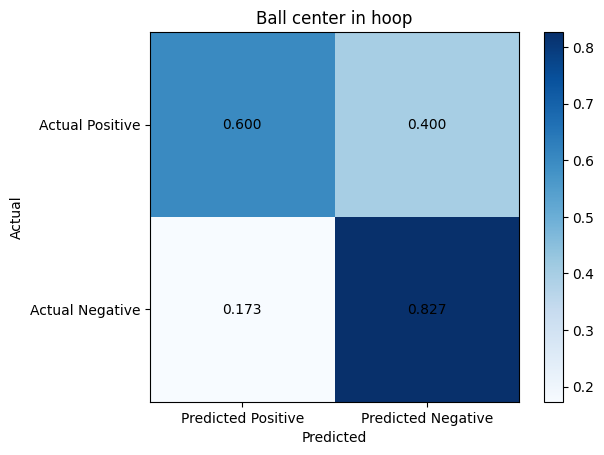

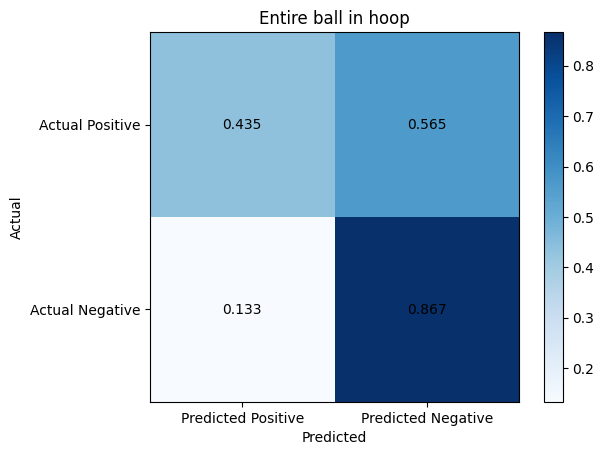

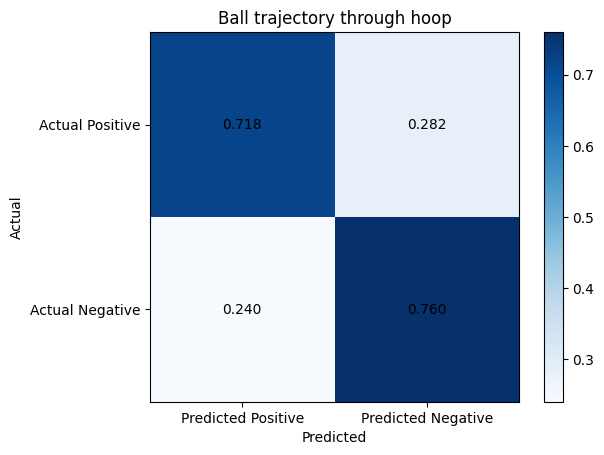

In [120]:
def calculate_classification_metrics(tp, tn, fp, fn):
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    return ( tpr, tnr,fpr, fnr)

# Example usage:
tp = 50
tn = 100
fp = 10
fn = 5

plot_confusion_matrix(calculate_classification_metrics(predicted_made3, predicted_not_made1, predicted_made1, predicted_not_made3), 'Ball center in hoop')
plot_confusion_matrix(calculate_classification_metrics(predicted_made4, predicted_not_made2, predicted_made2, predicted_not_made4), 'Entire ball in hoop')
plot_confusion_matrix(calculate_classification_metrics(predicted_made6, predicted_not_made5, predicted_made5, predicted_not_made6), 'Ball trajectory through hoop')



In [119]:
def calculate_classification_metrics(tp, tn, fp, fn):
    # tp, tn, fp, fn = float(tp), float(tn), float(fp), float(fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return accuracy, precision, recall

# Example usage:
tp = 50
tn = 100
fp = 10
fn = 5

print(calculate_classification_metrics(predicted_made3, predicted_not_made1, predicted_made1, predicted_not_made3))
print(calculate_classification_metrics(predicted_made4, predicted_not_made2, predicted_made2, predicted_not_made4))
print(calculate_classification_metrics(predicted_made6, predicted_not_made5, predicted_made5, predicted_not_made6))


(0.70625, 0.796875, 0.6)
(0.6375, 0.7872340425531915, 0.43529411764705883)
(0.7375, 0.7721518987341772, 0.7176470588235294)
